# Metropolis-Hastings

##### Keywords: metropolis-hastings, MCMC,  detailed balance, discrete sampling, transition matrix, metropolis

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

## Contents
{:.no_toc}
* 
{: toc}

## Extending to Metropolis-Hastings
Symmetric proposal distributions were a real restriction in the Metropolis setting. Limiting ourselves to symmetric proposals has a computational cost, too.

If you think about the $6x(1-x)$ "distribution" we don't want to propose samples outside of [0,1], since we know they'll be rejected. With Metropolis we wastefully make acceptance probability comparisons.

Out intuition may be that when our proposal gives a sample outside the support we should auto-reject it (instead of satying at the current value) and re-draw a better proposal. But this makes our proposal asymmetric and breaks detailed balance: stepping to a negative number and coming back are not symmetric: in one direction the proposal is impossible, the other proposal is very possible.

We really need to allow asymmetric distributions in our Metropolis algorithm. Hastings provides a very simple correction that works perfectly

Here is the outline code for metropolis hastings:

In [5]:
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted=0
    for i in range(nsamp):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

Look at the `proposalratio` term. Its a ratio of proposal pdfs. But its opposite to the ratio of the pdf that we want to sample from.

The intuition behind this is to correct the sampling of $q$ to match $p$. It corrects for any asymmetries in the proposal distribution. If the proposal prefers left over right, then we weigh the rightward moves more.

In the case of distributions with limited support (only positives, for example) one must be careful choosing a proposal. A good rule of thumb is that the proposal has the same or larger support then the target, with the same support being the best. 

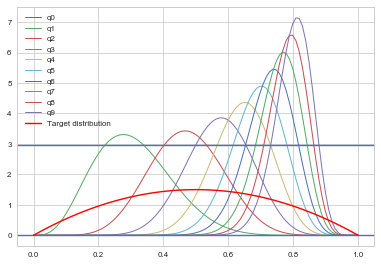

In [3]:
from scipy.stats import beta
f = lambda x: 6*x*(1-x)
xx= np.linspace(0,1,100)
for i,s in enumerate(np.linspace(0,1,10)):
    plt.plot(xx, beta.pdf(xx,40*s,10), lw=1, label="q"+str(i))
plt.axhline(beta.pdf(0.2, 20, 10),0,1)
plt.axhline(beta.pdf(0.5, 8, 10),0,1)


#plot the true function
plt.plot(xx, f(xx), 'r', label=u'Target distribution') 
plt.legend();

The plot above shows the target distribution (which has bounnded x values) and proposal distributions at various values of x. The key point is that each proposal distribution is 1) asymmetric 2) only proposing points inside the domain of $p$

## Proof of detailed balance

The transition matrix (or kernel) can be written in this form for Metropolis-Hastings is also:

$$T(x_i \vert x_{i-1}) = q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  \delta(x_{i-1} - x_i)r(x_{i-1})$$

where now the acceptance probability has changed to:

$$A(x_i, x_{i-1}) = min(1,  \frac{s(x_i) \times q(x_{i-1} \vert x_i)}{s(x_{i-1}) \times q(x_i \vert x_{i-1})}).$$ 

Everything else remains the same with the rejection term still:

$$r(x_i) = \int dy q(y \vert x_i)(1 - A(y, x_i)) = 1 - \int dy q(y \vert x_i) A(y, x_i).$$ 

Now, as in the Metropolis case, consider:

$$s(x_i)T( x_{i-1} \vert x_i ) =  s(x_i) q(x_{i-1} \vert x_{i})\,A(x_{i-1}, x_{i}) +  s(x_i) \delta(x_{i} - x_{i-1})r(x_{i})$$

and 

$$s(x_{i-1})T( x_{i} \vert x_{i-1} ) =  s(x_{i-1}) q(x_i \vert x_{i-1})\,A(x_i, x_{i-1}) +  s(x_{i-1})\delta(x_{i-1} - x_i)r(x_{i-1})$$

The second terms cancel for the same reason as before.

The comparison of the first two terms is just a bit harder than in the Metropolis case, but the cases are the same. The first two terms are trivially equal when A=1 because the proposal-ration must be 1. WOLOG, suppose 

$$s(x_i)\times q(x_{i-1} \vert x_i) <  s(x_{i-1}) \times q(x_i \vert x_{i-1})$$ 
then
$$A(x_i, x_{i-1}) < 1\ ,\ A(x_{i-1}, x_{i}) = 1$$

Then we are comparing:

$$\frac{s(x_i) \times q(x_{i-1} \vert x_i)}{s(x_{i-1}) \times q(x_i \vert x_{i-1})} \times  s(x_{i-1}) q(x_i \vert x_{i-1})$$

to $s(x_i) q(x_{i-1} \vert x_{i})$ which are again trivially equal.


## MH example

Let us sample from  $f(x)=0.554xe^{-(x/1.9)^2}$ which is a weibull distribution used in response time analysis.

A rule of thumb for choosing proposal distributions is to parametrize them in terms of their mean and variance or precision since that  provides a notion of "centeredness" which we can use for our proposals $x_{i-1}$. We then fix the variance to understand how widely we are sampling from.

As a proposal we shall use a Gamma Distribution with parametrization $$Gamma(x\tau, 1/\tau)$$ in the shape-scale parametrization. The mean of this Gamma then is $shape*scale$ so that x is the mean. $\tau$ is a precision parameter


In [6]:
from scipy.stats import gamma

#target distribution
f = lambda x: 0.554*x*np.exp(-(x/1.9)**2)

#build a function that takes in an x and returns a sample from the appropriate
#proposal distribution
t=10
def gammapdf(x_new, x_old):
    return gamma.pdf(x_new,x_old*t,scale=1/t)
def gammadraw(x_old):
    return gamma.rvs(x_old*t,scale=1/t)

#run the algorithm
samps,acc = metropolis_hastings(f, gammapdf, gammadraw, 100000, 1)

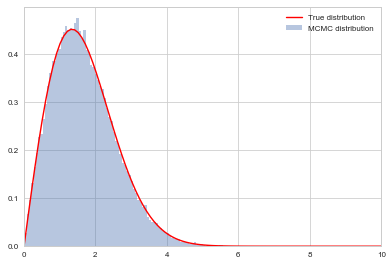

In [30]:
# plot our sample histogram
plt.hist(samps,bins=100, alpha=0.4, label=u'MCMC distribution', normed=True) 
somesamps=samps[1000::40000]
xx= np.linspace(0,10,100)
plt.plot(xx, f(xx), 'r', label=u'True distribution') 
plt.legend()
plt.xlim([0,10])
plt.show()